<a href="https://colab.research.google.com/github/codeby3/searchable-encryption/blob/main/security_evals/paillier/paillier_security_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

In [1]:
!pip install -qU beir sentence-transformers scikit-learn matplotlib seaborn phe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9

In [2]:
!pip install --force-reinstall --no-cache-dir numpy==1.26.4 scipy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 162.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
plotn

In [1]:
import os
import time
import numpy as np
from beir.datasets.data_loader import GenericDataLoader
from beir import util
from sentence_transformers import SentenceTransformer
import torch
from google.colab import userdata # Keep for Colab, comment out for local .py script
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
import shutil
import json

# Security-specific imports
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr

/usr/local/lib/python3.11/dist-packages/beir/datasets/data_loader.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
sys.path.append(os.getcwd())
import paillier as paillier_lib

In [3]:
# Generate a single Paillier key for the entire pipeline
# n_length determines key size and security (1024-bit is default, 2048+ for stronger security)
# Paillier is very computationally intensive, so keeping it at 1024 for these tests.
PAILLIER_KEY = paillier_lib.PaillierKey.generate_random(n_length=1024)
PAILLIER_SCALING_FACTOR = 1000 # Factor to scale floats to integers for Paillier encryption

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    print(f"Model 'all-MiniLM-L6-v2' loaded successfully on {device}.")
except Exception as e:
    print(f"Failed to load embedding model on {device}: {e}")
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
    print("Loaded model on CPU as a fallback.")
DIMENSION = 384 # Dimension for all-MiniLM-L6-v2

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model 'all-MiniLM-L6-v2' loaded successfully on cpu.


In [5]:
dataset_name = "fiqa" # Using FIQA as it's larger
beir_data_path = "./beir_datasets_security" # Separate path for clarity
os.makedirs(beir_data_path, exist_ok=True)
loaded_beir_data = {}

In [6]:
if os.path.exists(os.path.join(beir_data_path, dataset_name)):
    print(f"Dataset folder '{os.path.join(beir_data_path, dataset_name)}' already exists. Deleting to ensure fresh download.")
    shutil.rmtree(os.path.join(beir_data_path, dataset_name))

print(f"\nProcessing dataset: {dataset_name}")
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
out_dir = os.path.join(beir_data_path, dataset_name)

print(f"Downloading {dataset_name} from {url} to {out_dir}...")
data_path_after_unzip = util.download_and_unzip(url, out_dir)

try:
    corpus, _, _ = GenericDataLoader(data_folder=data_path_after_unzip).load(split="test")
    loaded_beir_data[dataset_name] = {"corpus": corpus}
    print(f"Successfully loaded corpus for {dataset_name}.")
    print(f"  Corpus size: {len(corpus)} documents")
    print(f"  [CRITICAL DEBUG] Actual loaded corpus size for '{dataset_name}': {len(loaded_beir_data[dataset_name]['corpus'])} documents.")
except Exception as e:
    raise RuntimeError(f"Error loading {dataset_name} corpus from '{data_path_after_unzip}': {e}")


Processing dataset: fiqa


./beir_datasets_security/fiqa/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

  0%|          | 0/57638 [00:00<?, ?it/s]

Successfully loaded corpus for fiqa.
  Corpus size: 57638 documents
  [CRITICAL DEBUG] Actual loaded corpus size for 'fiqa': 57638 documents.


In [7]:
# Security Evaluation Parameters
PAILLIER_COMMON_SAMPLE_SIZE = 500
COMMON_SECURITY_SAMPLE_SIZE = PAILLIER_COMMON_SAMPLE_SIZE # Unified sample size for all tests
SECURITY_M_KNOWN_DOCS = PAILLIER_COMMON_SAMPLE_SIZE # Attacker knows up to this many
SECURITY_N_SUBSET = PAILLIER_COMMON_SAMPLE_SIZE
SECURITY_T_TRIALS = PAILLIER_COMMON_SAMPLE_SIZE # Number of trials for NN Re-ID
SECURITY_ATTR_INF_SIZE = PAILLIER_COMMON_SAMPLE_SIZE # Size for Attribute Inference
SECURITY_MEM_INF_PROBES = PAILLIER_COMMON_SAMPLE_SIZE // 2 # Half for members, half for non-members
if SECURITY_MEM_INF_PROBES < 2:
    SECURITY_MEM_INF_PROBES = 2


# Helper Functions

In [8]:
# Helper function to get embeddings for security tests
def get_embeddings_for_security_tests(dataset_name: str, num_samples: int):
    corpus = loaded_beir_data[dataset_name]["corpus"]
    doc_ids = list(corpus.keys())

    print(f"  [DEBUG] get_embeddings_for_security_tests called for '{dataset_name}':")
    print(f"  [DEBUG]   Corpus has {len(doc_ids)} total documents.")
    print(f"  [DEBUG]   Requested num_samples: {num_samples}")

    if num_samples < len(doc_ids):
        sampled_doc_ids = np.random.choice(doc_ids, num_samples, replace=False)
        print(f"  [DEBUG]   Sampling {len(sampled_doc_ids)} documents.")
    else:
        sampled_doc_ids = doc_ids # Use all if fewer samples requested than available
        print(f"  [DEBUG]   Using ALL {len(sampled_doc_ids)} documents (requested >= available).")

    sampled_contents = [f"{corpus[did].get('title', '')} {corpus[did].get('text', '')}".strip() for did in sampled_doc_ids]

    # Generate plaintext embeddings (NumPy array)
    plaintext_embeddings = embedding_model.encode(sampled_contents, convert_to_numpy=True)

    # Encrypt embeddings using Paillier
    encrypted_embeddings_paillier = []
    for i, vec in enumerate(tqdm(plaintext_embeddings, desc="Encrypting embeddings")):
        # Paillier encryption is very slow, so tqdm is helpful here.
        # CRITICAL: Convert numpy array to Python list before encryption
        encrypted_result = paillier_lib.encrypt_vector(PAILLIER_KEY, vec.tolist(), PAILLIER_SCALING_FACTOR)
        # We store the ciphertext (normalized float list) and norm_params (string)
        encrypted_embeddings_paillier.append({
            'ciphertext': encrypted_result.ciphertext,
            'norm_params': encrypted_result.norm_params
        })

    print(f"  [DEBUG]   Returning {len(plaintext_embeddings)} plaintext and {len(encrypted_embeddings_paillier)} encrypted embeddings.")
    # Return plaintext as numpy array, encrypted as list of dicts (ciphertext, norm_params)
    return plaintext_embeddings, encrypted_embeddings_paillier, sampled_doc_ids

In [9]:
# --- Helper for Dot Product Calculation ---
def calculate_dot_product(vec1_plain: np.ndarray, vec2_plain: np.ndarray):
    """Calculates dot product for plaintext vectors."""
    return np.dot(vec1_plain, vec2_plain)

In [10]:
def calculate_encrypted_dot_product(key: paillier_lib.PaillierKey, enc_vec1: dict, enc_vec2_plain: np.ndarray):
    """
    Simulates dot product of encrypted vector with plaintext vector using Paillier homomorphic properties.
    This is typically how search would work: encrypted database, plaintext query.
    """
    # Deserialize encrypted vector 1
    recreated_enc_vec1 = paillier_lib._deserialize_encrypted_vector(key, enc_vec1['ciphertext'], enc_vec1['norm_params'])

    # Scale plaintext vector 2 for multiplication
    scaled_vec2_plain = [int(round(x * PAILLIER_SCALING_FACTOR)) for x in enc_vec2_plain.tolist()]

    # Perform homomorphic scalar multiplication and sum
    encrypted_dot_product = paillier_lib.paillier.EncryptedNumber(key.public_key, 0) # Initialize with encrypted zero
    for enc_val1, plain_val2 in zip(recreated_enc_vec1, scaled_vec2_plain):
        # (enc_val1 * plain_val2) is homomorphic multiplication
        encrypted_dot_product += (enc_val1 * plain_val2)

    # Decrypt the final dot product
    decrypted_dot_product = key.private_key.decrypt(encrypted_dot_product)

    # De-scale the result (dividing by scaling factor twice because both vectors were implicitly scaled)
    return decrypted_dot_product / (PAILLIER_SCALING_FACTOR * PAILLIER_SCALING_FACTOR)

# Testing Functions

In [11]:
def calculate_distance_matrix_paillier(vectors, key: paillier_lib.PaillierKey, metric='negative_dot_product', desc="Calculating Distances"): # ADDED 'desc' parameter
     """
     Calculates similarity/distance matrix for Paillier.
     'vectors' is a list of (plaintext_vector, encrypted_vector_dict) tuples.
     Metric should be 'negative_dot_product' for encrypted comparisons.
     """
     n = len(vectors)
     matrix = np.zeros((n, n))
     for i in tqdm(range(n), desc=desc): # Use the passed 'desc'
         for j in range(i + 1, n):
             plain_vec_i, enc_vec_i_dict = vectors[i]
             plain_vec_j, enc_vec_j_dict = vectors[j]

             if metric == 'euclidean':
                 val = euclidean(plain_vec_i, plain_vec_j)
             elif metric == 'cosine':
                 val = 1 - np.dot(plain_vec_i, plain_vec_j) / (np.linalg.norm(plain_vec_i) * np.linalg.norm(plain_vec_j))
             elif metric == 'dot_product':
                 val = np.dot(plain_vec_i, plain_vec_j)
             elif metric == 'negative_dot_product':
                 val = -calculate_encrypted_dot_product(key, enc_vec_i_dict, plain_vec_j)
             else:
                 raise ValueError("Metric must be 'euclidean', 'cosine', 'dot_product', or 'negative_dot_product'")
             matrix[i, j] = matrix[j, i] = val
     return matrix

In [12]:
def run_distance_structure_leakage(plaintext_paired_with_enc, key: paillier_lib.PaillierKey, metric='negative_dot_product'):
     """
     Calculates Spearman rank-correlation (rho) for similarity/distance matrices.
     Lower rho indicates more privacy.
     """
     if len(plaintext_paired_with_enc) < 2:
         print("Not enough samples for Distance-Structure Leakage.")
         return None

     print("  Calculating plaintext similarity matrix...")
     plain_embeds_only = [p for p, _ in plaintext_paired_with_enc]
     plain_sim_matrix = calculate_distance_matrix_paillier(
         [(p, None) for p in plain_embeds_only],
         key,
         metric='dot_product',
         desc="Plaintext Distances" # Add desc for tqdm
     )

     print("  Calculating encrypted similarity matrix...")
     enc_sim_matrix = calculate_distance_matrix_paillier(
         plaintext_paired_with_enc,
         key,
         metric=metric,
         desc="Encrypted Distances" # Add desc for tqdm
     )

     n_samples = len(plain_sim_matrix)
     upper_triangle_indices = np.triu_indices(n_samples, k=1)
     plain_similarities = plain_sim_matrix[upper_triangle_indices]
     enc_similarities = enc_sim_matrix[upper_triangle_indices]

     if np.std(plain_similarities) == 0 or np.std(enc_similarities) == 0:
         if np.all(plain_similarities == enc_similarities):
             return 1.0
         else:
             return 0.0

     rho, _ = spearmanr(plain_similarities, enc_similarities)
     return rho

In [13]:
def run_nn_re_identification_attack(corpus_plaintext_embeddings, corpus_encrypted_embeddings, attacker_known_size=SECURITY_M_KNOWN_DOCS, num_trials=SECURITY_T_TRIALS, metric='cosine'):
    """
    Simulates an NN re-identification attack.
    Attacker knows M encrypted docs. Probes an insider or outsider.
    Values near 1/M indicate strong privacy.
    """
    total_corpus_size = len(corpus_plaintext_embeddings)

    # If attacker_known_size is larger than corpus, reduce it
    if attacker_known_size > total_corpus_size:
        attacker_known_size = total_corpus_size // 2 # Use at most half for known if corpus is small
        print(f"Warning: attacker_known_size reduced to {attacker_known_size} due to corpus size.")

    # Ensure num_trials is not excessive. We need num_trials/2 insiders and num_trials/2 outsiders.
    # Outsiders must be distinct from known_indices.
    max_possible_insider_probes = attacker_known_size
    max_possible_outsider_probes = total_corpus_size - attacker_known_size

    num_insider_probes_to_attempt = num_trials // 2
    num_outsider_probes_to_attempt = num_trials - num_insider_probes_to_attempt # Handles odd num_trials

    if num_insider_probes_to_attempt > max_possible_insider_probes:
        num_insider_probes_to_attempt = max_possible_insider_probes
        print(f"Warning: Number of insider probes reduced to {num_insider_probes_to_attempt} due to attacker_known_size.")

    if num_outsider_probes_to_attempt > max_possible_outsider_probes:
        num_outsider_probes_to_attempt = max_possible_outsider_probes
        print(f"Warning: Number of outsider probes reduced to {num_outsider_probes_to_attempt} due to corpus size.")

    actual_num_trials = num_insider_probes_to_attempt + num_outsider_probes_to_attempt
    if actual_num_trials == 0 or num_insider_probes_to_attempt == 0:
        print("Warning: Cannot perform NN Re-ID attack - not enough valid trials/insider probes can be generated.")
        return {"Hit@1": None, "Hit@5": None, "random_baseline": 1/attacker_known_size if attacker_known_size > 0 else 0}

    print(f"  Running NN Re-ID with attacker_known_size={attacker_known_size}, actual_num_trials={actual_num_trials} ({num_insider_probes_to_attempt} insiders, {num_outsider_probes_to_attempt} outsiders).")


    # Simulate attacker's prior knowledge: M encrypted documents
    # Simulate attacker's prior knowledge: M encrypted documents
    all_corpus_indices = np.arange(total_corpus_size)
    # Ensure attacker_known_size does not exceed total_corpus_size
    attacker_known_size = min(attacker_known_size, total_corpus_size)

    known_indices = np.random.choice(all_corpus_indices, attacker_known_size, replace=False)
    known_plaintext_embeds = corpus_plaintext_embeddings[known_indices]
    known_encrypted_embeds = np.array(corpus_encrypted_embeddings, dtype=object)[known_indices] # Ensure Paillier type

    # Pool for outsider probes
    outsider_pool_indices = np.setdiff1d(all_corpus_indices, known_indices)

    # Determine the actual number of insider/outsider probes we can attempt
    actual_insider_probes_count = min(num_trials // 2, attacker_known_size)
    actual_outsider_probes_count = min(num_trials // 2, len(outsider_pool_indices))

    # Total trials will be the sum of what we can actually run
    actual_num_trials = actual_insider_probes_count + actual_outsider_probes_count

    if actual_num_trials == 0 or actual_insider_probes_count == 0:
        print("Warning: Cannot perform NN Re-ID attack - not enough valid trials/insider probes can be generated.")
        return {"Hit@1": None, "Hit@5": None, "random_baseline": 1/attacker_known_size if attacker_known_size > 0 else 0}

    print(f"  Running NN Re-ID with attacker_known_size={attacker_known_size}, actual_num_trials={actual_num_trials} ({actual_insider_probes_count} insiders, {actual_outsider_probes_count} outsiders).")

    hits_at_1 = 0
    hits_at_5 = 0
    total_successful_insider_probes = 0

    # Generate a mixed list of probe types based on actual counts
    probe_types = [True] * actual_insider_probes_count + [False] * actual_outsider_probes_count
    np.random.shuffle(probe_types)

    # Keep track of indices already used for probes to avoid duplicates
    # Use lists to store available indices, and pop from them
    available_known_indices_for_probes = list(known_indices)
    available_outsider_indices_for_probes = list(outsider_pool_indices)
    np.random.shuffle(available_known_indices_for_probes)
    np.random.shuffle(available_outsider_indices_for_probes)


    for is_insider_trial in tqdm(probe_types, desc="NN Re-ID Attack Trials"):
        probe_original_idx = None
        probe_plaintext_vec = None
        true_known_idx_in_subset = -1

        if is_insider_trial:
            if not available_known_indices_for_probes:
                continue # No more unique insider probes available

            probe_original_idx = available_known_indices_for_probes.pop() # Get a unique known index
            probe_plaintext_vec = corpus_plaintext_embeddings[probe_original_idx]
            true_known_idx_in_subset = np.where(known_indices == probe_original_idx)[0][0]
            total_successful_insider_probes += 1
        else: # Outsider trial
            if not available_outsider_indices_for_probes:
                continue # No more unique outsider probes available

            probe_original_idx = available_outsider_indices_for_probes.pop() # Get a unique outsider index
            probe_plaintext_vec = corpus_plaintext_embeddings[probe_original_idx]

        # If probe_plaintext_vec is None, it means we ran out of available probes of a certain type
        if probe_plaintext_vec is None:
            continue

        # Re-encrypt the probe with a fresh IV/key (simulating a query)
        probe_encrypted_fresh_iv_dict = paillier_lib.encrypt_vector(PAILLIER_KEY, probe_plaintext_vec.tolist(), PAILLIER_SCALING_FACTOR)

        # Compute distances (negative dot product) to all known encrypted documents
        similarities = []
        for i in range(len(known_encrypted_embeds)):
            # known_encrypted_embeds[i] is already a dict {'ciphertext': ..., 'norm_params': ...}
            sim = calculate_encrypted_dot_product(PAILLIER_KEY, known_encrypted_embeds[i], probe_plaintext_vec)
            similarities.append(sim)

        # For ranking, higher similarity is better.
        # Rank of the true insider in the sorted similarities (descending)
        if is_insider_trial:
            if true_known_idx_in_subset < 0 or true_known_idx_in_subset >= len(similarities):
                continue # Safety check

            true_sim = similarities[true_known_idx_in_subset]

            # Count how many similarities are greater than or equal to the true similarity
            # This gives its rank (1-based), assuming higher similarity is better (which it is for dot product)
            rank_star = np.sum(np.array(similarities) >= true_sim)

            if rank_star == 1:
                hits_at_1 += 1
            if rank_star <= 5:
                hits_at_5 += 1

    if total_successful_insider_probes == 0:
        print("Warning: No valid insider probes were successfully executed for NN Re-ID attack to calculate hits.")
        return {"Hit@1": 0.0, "Hit@5": 0.0, "random_baseline": 1/attacker_known_size if attacker_known_size > 0 else 0}

    hit_1 = hits_at_1 / total_successful_insider_probes
    hit_5 = hits_at_5 / total_successful_insider_probes
    random_baseline = 1 / attacker_known_size if attacker_known_size > 0 else 0

    return {"Hit@1": hit_1, "Hit@5": hit_5, "random_baseline": random_baseline}

In [14]:
def run_attribute_inference(embeddings_paired_with_enc, labels, test_size=0.1, random_state=42):
    """
    Trains a logistic regression model on vectors to predict attributes.
    Higher accuracy indicates more semantic leakage.
    For Paillier, we use the plaintext embeddings for the 'plaintext' accuracy
    and the normalized ciphertext (float list) for the 'encrypted' accuracy.
    """
    if len(embeddings_paired_with_enc) < 100 or len(np.unique(labels)) < 2:
        print("Not enough samples or unique labels for Attribute Inference.")
        return None

    plain_X = np.array([p for p, _ in embeddings_paired_with_enc])
    enc_X = np.array([e['ciphertext'] for _, e in embeddings_paired_with_enc])
    y = labels

    plain_acc = None
    enc_acc = None

    # Plaintext Accuracy
    print("  Training Plaintext Logistic Regression...")
    try:
        X_train_plain, X_test_plain, y_train, y_test = train_test_split(plain_X, y, test_size=test_size, random_state=random_state, stratify=y)
        model_plain = LogisticRegression(max_iter=1000, solver='liblinear', random_state=random_state)
        model_plain.fit(X_train_plain, y_train)
        y_pred_plain = model_plain.predict(X_test_plain)
        plain_acc = accuracy_score(y_test, y_pred_plain)
        print("  Plaintext Logistic Regression training complete.")
    except Exception as e:
        print(f"Error in Plaintext Attribute Inference training/prediction: {e}")

    # Encrypted Accuracy (using normalized ciphertext floats)
    print("  Training Encrypted Logistic Regression...")
    try:
        X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(enc_X, y, test_size=test_size, random_state=random_state, stratify=y)
        model_enc = LogisticRegression(max_iter=1000, solver='liblinear', random_state=random_state)
        model_enc.fit(X_train_enc, y_train_enc)
        y_pred_enc = model_enc.predict(X_test_enc)
        enc_acc = accuracy_score(y_test_enc, y_pred_enc)
        print("  Encrypted Logistic Regression training complete.")
    except Exception as e:
        print(f"Error in Encrypted Attribute Inference training/prediction: {e}")

    return plain_acc, enc_acc

In [15]:
def run_membership_inference(corpus_plaintext_embeddings, corpus_encrypted_embeddings, key: paillier_lib.PaillierKey, num_probes=SECURITY_MEM_INF_PROBES, metric='negative_dot_product'):
    """
    Tests membership inference via minimum distance (or max similarity).
    AUC near 0.5 indicates no advantage over chance.
    """
    total_corpus_size = len(corpus_plaintext_embeddings)
    if total_corpus_size < num_probes * 2:
        print(f"Warning: Not enough documents for Membership Inference. Need at least {num_probes*2}. Skipping.")
        return None

    indices = np.arange(total_corpus_size)
    actual_num_probes = num_probes

    if total_corpus_size < actual_num_probes * 2:
        actual_num_probes = total_corpus_size // 2
        print(f"Warning: Corpus size ({total_corpus_size}) is too small for {num_probes} members and {num_probes} non-members. Reducing probe count to {actual_num_probes}.")

    member_indices = np.random.choice(indices, actual_num_probes, replace=False)
    non_member_indices = np.setdiff1d(indices, member_indices)
    non_member_indices = np.random.choice(non_member_indices, actual_num_probes, replace=False)

    member_probes_plaintext = corpus_plaintext_embeddings[member_indices]
    non_member_probes_plaintext = corpus_plaintext_embeddings[non_member_indices]

    all_probes_plaintext = np.concatenate((member_probes_plaintext, non_member_probes_plaintext))
    true_labels = np.array([1]*actual_num_probes + [0]*actual_num_probes)

    max_similarities = []

    for q_plain in tqdm(all_probes_plaintext, desc="Membership Inference Searches"):
         similarities_to_corpus = []
         for z_i_encrypted_dict in corpus_encrypted_embeddings:
             sim = calculate_encrypted_dot_product(key, z_i_encrypted_dict, q_plain)
             similarities_to_corpus.append(sim)

         if not similarities_to_corpus:
             max_similarities.append(0.0)
         else:
             max_similarities.append(np.max(similarities_to_corpus))
    scores = np.array(max_similarities)

    if len(np.unique(true_labels)) < 2:
        print("Not enough unique labels for ROC AUC calculation.")
        return None

    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [16]:
def run_absolute_distance_distortion(plaintext_paired_with_enc, key: paillier_lib.PaillierKey, metric='negative_dot_product'):
    """
    Calculates the mean absolute similarity distortion.
    Larger Delta indicates stronger obfuscation.
    """
    if len(plaintext_paired_with_enc) < 2:
        print("Not enough samples for Absolute Distance Distortion.")
        return None

    # Calculate plaintext dot product matrix for correlation
    print("  Calculating plaintext similarity matrix for distortion...")
    plain_embeds_only = [p for p, _ in plaintext_paired_with_enc]
    plain_sim_matrix = calculate_distance_matrix_paillier(
        [(p, None) for p in plain_embeds_only],
        key,
        metric='dot_product',
        desc="Plain Distortions" # Add desc for tqdm
    )

    print("  Calculating encrypted similarity matrix for distortion...")
    enc_sim_matrix = calculate_distance_matrix_paillier(
        plaintext_paired_with_enc,
        key,
        metric=metric,
        desc="Encrypted Distortions" # Add desc for tqdm
    )

    n_samples = len(plain_sim_matrix)
    upper_triangle_indices = np.triu_indices(n_samples, k=1)
    plain_similarities = plain_sim_matrix[upper_triangle_indices]
    enc_similarities = enc_sim_matrix[upper_triangle_indices]

    distortions = []
    for p_sim, e_sim in zip(plain_similarities, enc_similarities):
        # We are comparing dot products.
        # Delta = |Plain_Sim - Enc_Sim| / |Plain_Sim|
        if p_sim == 0: # Avoid division by zero if plaintext similarity is zero
            continue
        delta_ij = np.abs(p_sim - e_sim) / np.abs(p_sim) # Use absolute value for relative change
        distortions.append(delta_ij)

    if not distortions:
        return 0.0

    return np.mean(distortions)

# Getting embeddings with Paillier Encryption

In [17]:
security_results = {}

dataset_for_security = "fiqa"

In [ ]:
corpus_plain_embeds, corpus_enc_embeds_paillier, _ = get_embeddings_for_security_tests(
    dataset_for_security, COMMON_SECURITY_SAMPLE_SIZE
)

# Pair them up for functions that need both for comparison
corpus_paired_embeds = list(zip(corpus_plain_embeds, corpus_enc_embeds_paillier))

  [DEBUG] get_embeddings_for_security_tests called for 'fiqa':
  [DEBUG]   Corpus has 57638 total documents.
  [DEBUG]   Requested num_samples: 1000
  [DEBUG]   Sampling 1000 documents.


Encrypting embeddings:   0%|          | 0/1000 [00:00<?, ?it/s]

  [DEBUG]   Returning 1000 plaintext and 1000 encrypted embeddings.


In [ ]:
save_dir = "./saved_security_eval_data"
os.makedirs(save_dir, exist_ok=True)

plain_embeds_filename = os.path.join(save_dir, "paillier_plain_embeds.npy")
enc_embeds_filename = os.path.join(save_dir, "paillier_enc_embeds.pkl") # .pkl for list of dicts

print(f"\n--- Saving Embeddings to {save_dir} ---")

try:
    # Save plaintext embeddings (NumPy array)
    np.save(plain_embeds_filename, corpus_plain_embeds)
    print(f"Plaintext embeddings saved to {plain_embeds_filename}")

    # Save encrypted embeddings (list of lists/dicts) using pickle
    import pickle
    with open(enc_embeds_filename, 'wb') as f: pickle.dump(corpus_enc_embeds_paillier, f)
    print(f"Encrypted embeddings saved to {enc_embeds_filename}")

except Exception as e:
    print(f"Error saving embeddings: {e}")


--- Saving Embeddings to ./saved_security_eval_data ---
Error saving embeddings: name 'corpus_plain_embeds' is not defined


## Load embeddings locally

In [18]:
# Define the directory where files were saved
load_dir = "./saved_security_eval_data"

plain_embeds_filename = os.path.join(load_dir, "paillier_plain_embeds.npy")
enc_embeds_filename = os.path.join(load_dir, "paillier_enc_embeds.pkl")

print(f"\n--- Loading Embeddings from {load_dir} ---")

try:
    # Load plaintext embeddings
    corpus_plain_embeds = np.load(plain_embeds_filename)
    print(f"Plaintext embeddings loaded from {plain_embeds_filename} (Shape: {corpus_plain_embeds.shape})")

    # Load encrypted embeddings
    import pickle
    with open(enc_embeds_filename, 'rb') as f:
        corpus_enc_embeds_paillier = pickle.load(f)
    print(f"Encrypted embeddings loaded from {enc_embeds_filename} (Count: {len(corpus_enc_embeds_paillier)})")

    total_loaded_count = len(corpus_plain_embeds)
    print(f"Original loaded count: {total_loaded_count} embeddings.")

    # Check if we need to sample down
    if total_loaded_count > PAILLIER_COMMON_SAMPLE_SIZE:
        print(f"Sampling down to {PAILLIER_COMMON_SAMPLE_SIZE} embeddings as requested...")

        # Generate random indices to select
        # Use replace=False to ensure we get unique embeddings
        sample_indices = np.random.choice(total_loaded_count, PAILLIER_COMMON_SAMPLE_SIZE, replace=False)

        # Sample both the plaintext and encrypted embeddings using the same indices
        corpus_plain_embeds = corpus_plain_embeds[sample_indices]
        corpus_enc_embeds_paillier = [corpus_enc_embeds_paillier[i] for i in sample_indices]

        print(f"New plaintext embedding shape: {corpus_plain_embeds.shape}")
        print(f"New encrypted embedding count: {len(corpus_enc_embeds_paillier)}")
    else:
        print("Loaded count is less than or equal to the sample size. Using all loaded embeddings.")

    # Recreate the paired list with the (potentially smaller) sampled data
    corpus_paired_embeds = list(zip(corpus_plain_embeds, corpus_enc_embeds_paillier))
    print(f"\n'corpus_paired_embeds' recreated with {len(corpus_paired_embeds)} pairs.")


except FileNotFoundError:
    print(f"Error: Embeddings files not found in {load_dir}. Please ensure they were saved correctly.")
    print("You might need to run the embedding generation part of the pipeline first.")
    exit()
except Exception as e:
    print(f"Error loading and sampling embeddings: {e}")
    exit()


--- Loading Embeddings from ./saved_security_eval_data ---
Plaintext embeddings loaded from ./saved_security_eval_data/paillier_plain_embeds.npy (Shape: (1000, 384))
Encrypted embeddings loaded from ./saved_security_eval_data/paillier_enc_embeds.pkl (Count: 1000)
Original loaded count: 1000 embeddings.
Sampling down to 500 embeddings as requested...
New plaintext embedding shape: (500, 384)
New encrypted embedding count: 500

'corpus_paired_embeds' recreated with 500 pairs.


In [19]:
# --- Helper function to save current security results ---
def save_current_security_results(results_dict, filename_prefix):
    save_dir = "./saved_security_eval_data"
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{filename_prefix}_security_results.json")
    try:
        with open(filename, 'w') as f:
            json.dump(results_dict, f, indent=4)
        print(f"  --> Current security results saved to {filename}")
    except Exception as e:
        print(f"  --> ERROR saving current security results to {filename}: {e}")

# --- Code to Load Pre-existing Security Results (if resuming) ---
# This block will attempt to load the 'security_results' dictionary if it exists.
def load_existing_security_results(filename_prefix):
    load_dir = "./saved_security_eval_data"
    filename = os.path.join(load_dir, f"{filename_prefix}_security_results.json")
    if os.path.exists(filename):
        try:
            with open(filename, 'r') as f:
                loaded_results = json.load(f)
            print(f"\n--- Loaded existing security results from {filename} ---")
            return loaded_results
        except Exception as e:
            print(f"Error loading existing security results from {filename}: {e}")
            return {} # Return empty dict on error
    return {} # Return empty dict if file not found

current_results_filename_prefix = "paillier"

# Attempt to load previous results at the start of the execution block
security_results = load_existing_security_results(current_results_filename_prefix)


--- Loaded existing security results from ./saved_security_eval_data/paillier_security_results.json ---


# Running tests

In [ ]:
# Test 1: Distance-Structure Leakage (Spearman rho)
if "Similarity_Structure_Leakage_rho" not in security_results: # Check if already done
    print("\nRunning Similarity-Structure Leakage (Spearman ρ) using Dot Product...")
    rho_val = run_distance_structure_leakage(corpus_paired_embeds, PAILLIER_KEY, metric='negative_dot_product')
    security_results["Similarity_Structure_Leakage_rho"] = rho_val
    print(f"  Spearman ρ: {rho_val:.4f}" if rho_val is not None else "  Spearman ρ: N/A")
    save_current_security_results(security_results, current_results_filename_prefix) # SAVE HERE

else:
    print("\nSkipping Distance-Structure Leakage (already in results).")


Running Similarity-Structure Leakage (Spearman ρ) using Dot Product...
  Calculating plaintext similarity matrix...


Plaintext Distances:   0%|          | 0/500 [00:00<?, ?it/s]

  Calculating encrypted similarity matrix...


Encrypted Distances:   0%|          | 0/500 [00:00<?, ?it/s]

  Spearman ρ: nan
  --> Current security results saved to ./saved_security_eval_data/paillier_security_results.json


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/tmp/ipython-input-12-2918662082.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(plain_similarities, enc_similarities)


In [ ]:
# Test 2: Nearest-Neighbour Re-Identification Attack (Hit@1, Hit@5)
if "NN_ReID_Hit@1" not in security_results: # Check if already done
    print("\nRunning Nearest-Neighbour Re-Identification Attack (using Dot Product)...")
    nn_re_id_results = run_nn_re_identification_attack(
        corpus_plain_embeds,
        corpus_enc_embeds_paillier,
        attacker_known_size=SECURITY_M_KNOWN_DOCS,
        num_trials=SECURITY_T_TRIALS,
        metric='negative_dot_product'
    )
    security_results["NN_ReID_Hit@1"] = nn_re_id_results.get("Hit@1")
    security_results["NN_ReID_Hit@5"] = nn_re_id_results.get("Hit@5")
    security_results["NN_ReID_Random_Baseline"] = nn_re_id_results.get("random_baseline")
    print(f"  Hit@1: {nn_re_id_results.get('Hit@1', 'N/A'):.4f}" if isinstance(nn_re_id_results.get('Hit@1'), (int, float)) else f"  Hit@1: {nn_re_id_results.get('Hit@1', 'N/A')}")
    print(f"  Hit@5: {nn_re_id_results.get('Hit@5', 'N/A'):.4f}" if isinstance(nn_re_id_results.get('Hit@5'), (int, float)) else f"  Hit@5: {nn_re_id_results.get('Hit@5', 'N/A')}")
    print(f"  Random Baseline (1/M): {nn_re_id_results.get('random_baseline', 'N/A'):.4f}" if isinstance(nn_re_id_results.get('random_baseline'), (int, float)) else f"  Random Baseline: {nn_re_id_results.get('random_baseline', 'N/A')}")
    save_current_security_results(security_results, current_results_filename_prefix) # SAVE HERE
else:
    print("\nSkipping Nearest-Neighbour Re-Identification Attack (already in results).")


Running Nearest-Neighbour Re-Identification Attack (using Dot Product)...
  Running NN Re-ID with attacker_known_size=500, actual_num_trials=250 (250 insiders, 0 outsiders).
  Running NN Re-ID with attacker_known_size=500, actual_num_trials=250 (250 insiders, 0 outsiders).


NN Re-ID Attack Trials:   0%|          | 0/250 [00:00<?, ?it/s]

  Hit@1: 0.0000
  Hit@5: 0.0000
  Random Baseline (1/M): 0.0020
  --> Current security results saved to ./saved_security_eval_data/paillier_security_results.json


In [ ]:
# Test 3: Attribute-Inference on Encrypted Vectors (Accuracy)
if "Attr_Inf_Plain_Accuracy" not in security_results: # Check if already done
    print("\nRunning Attribute-Inference...")
    dummy_labels = np.random.randint(0, 2, size=len(corpus_paired_embeds))

    plain_acc, enc_acc = run_attribute_inference(corpus_paired_embeds, dummy_labels)
    security_results["Attr_Inf_Plain_Accuracy"] = plain_acc
    security_results["Attr_Inf_Enc_Accuracy"] = enc_acc
    print(f"  Plaintext Accuracy: {plain_acc:.4f}" if plain_acc is not None else "  Plaintext Accuracy: N/A")
    print(f"  Encrypted Accuracy: {enc_acc:.4f}" if enc_acc is not None else "  Encrypted Accuracy: N/A")
    save_current_security_results(security_results, current_results_filename_prefix)
else:
    print("\nSkipping Attribute-Inference (already in results).")



Running Attribute-Inference...
  Training Plaintext Logistic Regression...
  Plaintext Logistic Regression training complete.
  Training Encrypted Logistic Regression...
  Encrypted Logistic Regression training complete.
  Plaintext Accuracy: 0.5400
  Encrypted Accuracy: 0.5000
  --> Current security results saved to ./saved_security_eval_data/paillier_security_results.json


In [ ]:
# Test 4: Membership-Inference via Maximum Similarity (Dot Product)
if "Membership_Inf_AUC" not in security_results: # Check if already done
    print("\nRunning Membership-Inference via Maximum Similarity (Dot Product)...")
    auc_val = run_membership_inference(corpus_plain_embeds, corpus_enc_embeds_paillier, PAILLIER_KEY, num_probes=SECURITY_MEM_INF_PROBES, metric='negative_dot_product')
    security_results["Membership_Inf_AUC"] = auc_val
    print(f"  Membership Inference AUC: {auc_val:.4f}" if auc_val is not None else "  Membership Inference AUC: N/A")
    save_current_security_results(security_results, current_results_filename_prefix)
else:
    print("\nSkipping Membership-Inference (already in results).")


Running Membership-Inference via Maximum Similarity (Dot Product)...


Membership Inference Searches:   0%|          | 0/500 [00:00<?, ?it/s]

  Membership Inference AUC: 0.5000
  --> Current security results saved to ./saved_security_eval_data/paillier_security_results.json


In [20]:
# Test 5: Absolute Distance-Distortion (Mean Delta)
if "Absolute_Similarity_Distortion_Delta" not in security_results: # Check if already done
    print("\nRunning Absolute Similarity-Distortion (Mean Δ) using Dot Product...")
    delta_val = run_absolute_distance_distortion(corpus_paired_embeds, PAILLIER_KEY, metric='negative_dot_product')
    security_results["Absolute_Similarity_Distortion_Delta"] = delta_val
    print(f"  Mean Δ: {delta_val:.4f}" if delta_val is not None else "  Mean Δ: N/A")
    save_current_security_results(security_results, current_results_filename_prefix) # SAVE HERE
else:
    print("\nSkipping Absolute Distance-Distortion (already in results).")


Running Absolute Similarity-Distortion (Mean Δ) using Dot Product...
  Calculating plaintext similarity matrix for distortion...


Plain Distortions:   0%|          | 0/500 [00:00<?, ?it/s]

  Calculating encrypted similarity matrix for distortion...


Encrypted Distortions:   0%|          | 0/500 [00:00<?, ?it/s]

  Mean Δ: 581818927932824036334104838078537704649688745551856680594546360981420363975577653553543843765335335407799998714224455297997163103971739406999437352173427980306119736366280906882825130558593844638088826026862695201266080880343138023892009386785717446037322691137519242553294250247909454178031605280407552.0000
  --> Current security results saved to ./saved_security_eval_data/paillier_security_results.json


# Visualising Results


Security Results DataFrame for plotting:
   NN_ReID_Hit@1  NN_ReID_Hit@5  NN_ReID_Random_Baseline  Similarity_Structure_Leakage_rho  Attr_Inf_Plain_Accuracy  Attr_Inf_Enc_Accuracy  Membership_Inf_AUC  Absolute_Similarity_Distortion_Delta
0            0.0            0.0                    0.002                               NaN                     0.54                    0.5                 0.5                         5.818189e+302


/tmp/ipython-input-22-317038540.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Spearman ρ"], y=[security_df["Similarity_Structure_Leakage_rho"].iloc[0]], palette="crest")


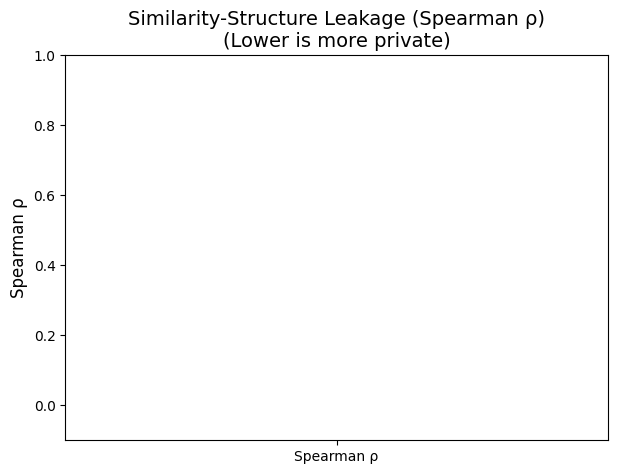

/tmp/ipython-input-22-317038540.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Value", data=nn_reid_plot_df, palette="viridis")


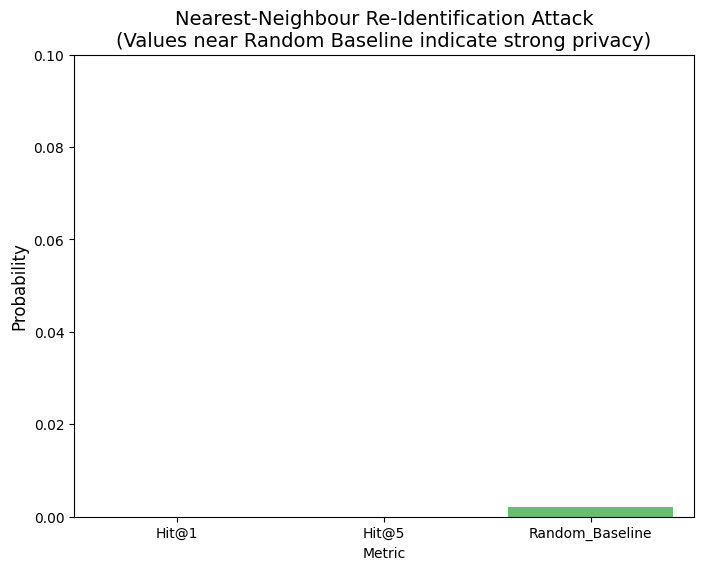

/tmp/ipython-input-22-317038540.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Type", y="Accuracy", data=attr_inf_plot_df, palette="plasma")


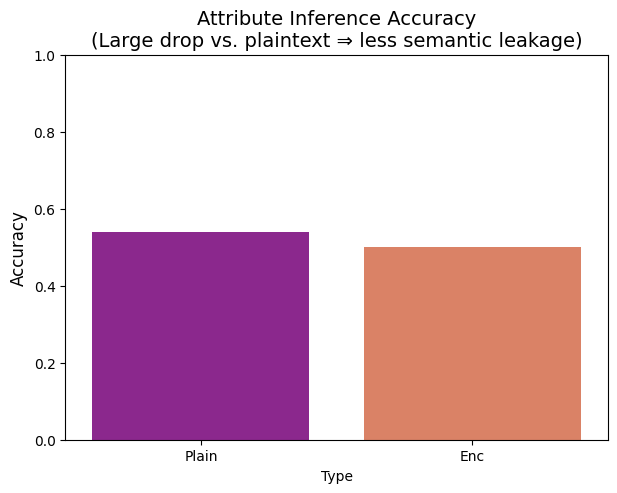

/tmp/ipython-input-22-317038540.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Membership Inference AUC"], y=[security_df["Membership_Inf_AUC"].iloc[0]], palette="rocket")


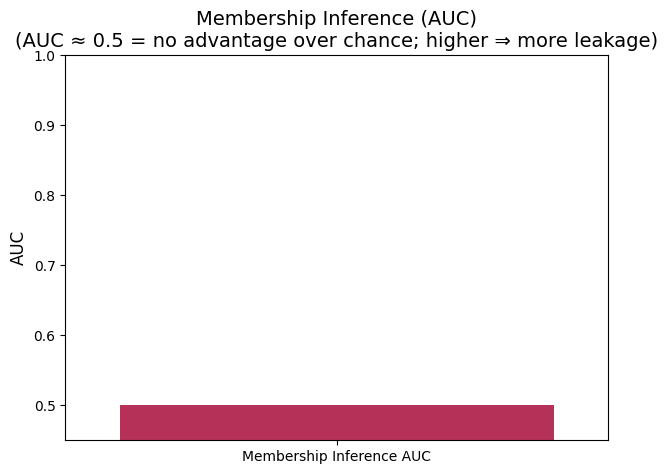

/tmp/ipython-input-22-317038540.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Mean Δ"], y=[security_df["Absolute_Similarity_Distortion_Delta"].iloc[0]], palette="magma")


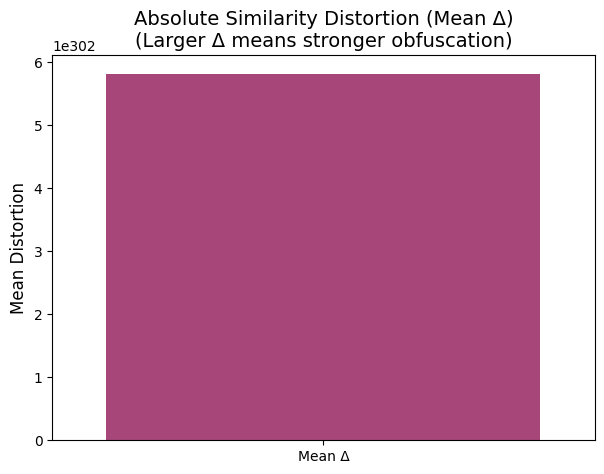


--- Phase 7: Security Visualizations Generated ---


In [22]:
security_df = pd.DataFrame([security_results])
pd.set_option('display.max_columns', None)
print("\nSecurity Results DataFrame for plotting:")
print(security_df.to_string())

# Plotting Distance/Similarity Structure Leakage (Spearman Rho)
if "Similarity_Structure_Leakage_rho" in security_df.columns and security_df["Similarity_Structure_Leakage_rho"].iloc[0] is not None:
    plt.figure(figsize=(7, 5))
    sns.barplot(x=["Spearman ρ"], y=[security_df["Similarity_Structure_Leakage_rho"].iloc[0]], palette="crest")
    plt.title("Similarity-Structure Leakage (Spearman ρ)\n(Lower is more private)", fontsize=14)
    plt.ylabel("Spearman ρ", fontsize=12)
    plt.ylim(-0.1, 1.0)
    plt.show()

# Plotting NN Re-Identification
nn_reid_metrics = ["NN_ReID_Hit@1", "NN_ReID_Hit@5", "NN_ReID_Random_Baseline"]
if all(m in security_df.columns and security_df[m].iloc[0] is not None for m in nn_reid_metrics):
    nn_reid_plot_data = []
    for metric_name in nn_reid_metrics:
        value = security_df[metric_name].iloc[0]
        if isinstance(value, (int, float)):
            nn_reid_plot_data.append({"Metric": metric_name.replace("NN_ReID_", ""), "Value": value})

    if nn_reid_plot_data:
        nn_reid_plot_df = pd.DataFrame(nn_reid_plot_data)

        plt.figure(figsize=(8, 6))
        sns.barplot(x="Metric", y="Value", data=nn_reid_plot_df, palette="viridis")
        plt.title("Nearest-Neighbour Re-Identification Attack\n(Values near Random Baseline indicate strong privacy)", fontsize=14)
        plt.ylabel("Probability", fontsize=12)
        plt.ylim(0, max(nn_reid_plot_df["Value"].max() * 1.2, 0.1))
        plt.show()
    else:
        print("Skipping NN Re-Identification plot due to missing data.")

# Plotting Attribute Inference
attr_inf_metrics = ["Attr_Inf_Plain_Accuracy", "Attr_Inf_Enc_Accuracy"]
if all(m in security_df.columns and security_df[m].iloc[0] is not None for m in attr_inf_metrics):
    attr_inf_plot_data = []
    for metric_name in attr_inf_metrics:
        value = security_df[metric_name].iloc[0]
        if isinstance(value, (int, float)):
            attr_inf_plot_data.append({"Type": metric_name.replace("Attr_Inf_", "").replace("_Accuracy", ""), "Accuracy": value})

    if attr_inf_plot_data:
        attr_inf_plot_df = pd.DataFrame(attr_inf_plot_data)

        plt.figure(figsize=(7, 5))
        sns.barplot(x="Type", y="Accuracy", data=attr_inf_plot_df, palette="plasma")
        plt.title("Attribute Inference Accuracy\n(Large drop vs. plaintext ⇒ less semantic leakage)", fontsize=14)
        plt.ylabel("Accuracy", fontsize=12)
        plt.ylim(0, 1)
        plt.show()
    else:
        print("Skipping Attribute Inference plot due to missing data.")

# Plotting Membership Inference
if "Membership_Inf_AUC" in security_df.columns and security_df["Membership_Inf_AUC"].iloc[0] is not None:
    plt.figure(figsize=(7, 5))
    sns.barplot(x=["Membership Inference AUC"], y=[security_df["Membership_Inf_AUC"].iloc[0]], palette="rocket")
    plt.title("Membership Inference (AUC)\n(AUC ≈ 0.5 = no advantage over chance; higher ⇒ more leakage)", fontsize=14)
    plt.ylabel("AUC", fontsize=12)
    plt.ylim(0.45, 1.0)
    plt.show()

# Plotting Absolute Distance Distortion
if "Absolute_Similarity_Distortion_Delta" in security_df.columns and security_df["Absolute_Similarity_Distortion_Delta"].iloc[0] is not None:
    plt.figure(figsize=(7, 5))
    sns.barplot(x=["Mean Δ"], y=[security_df["Absolute_Similarity_Distortion_Delta"].iloc[0]], palette="magma")
    plt.title("Absolute Similarity Distortion (Mean Δ)\n(Larger Δ means stronger obfuscation)", fontsize=14)
    plt.ylabel("Mean Distortion", fontsize=12)
    plt.show()

print("\n--- Phase 7: Security Visualizations Generated ---")


--- Phase 7: Generating Improved Security Visualizations ---

Security Results DataFrame for plotting:
   NN_ReID_Hit@1  NN_ReID_Hit@5  NN_ReID_Random_Baseline  Similarity_Structure_Leakage_rho  Attr_Inf_Plain_Accuracy  Attr_Inf_Enc_Accuracy  Membership_Inf_AUC  Absolute_Similarity_Distortion_Delta
0            0.0            0.0                    0.002                               NaN                     0.54                    0.5                 0.5                         5.818189e+302


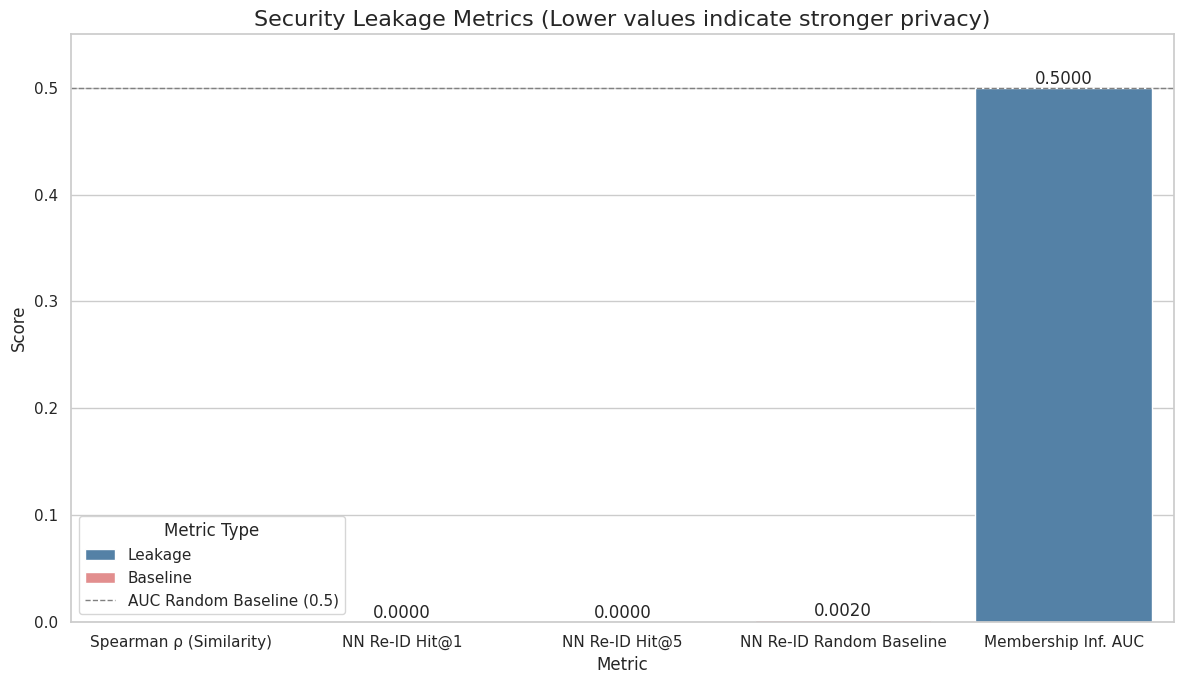

/tmp/ipython-input-23-2903243128.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


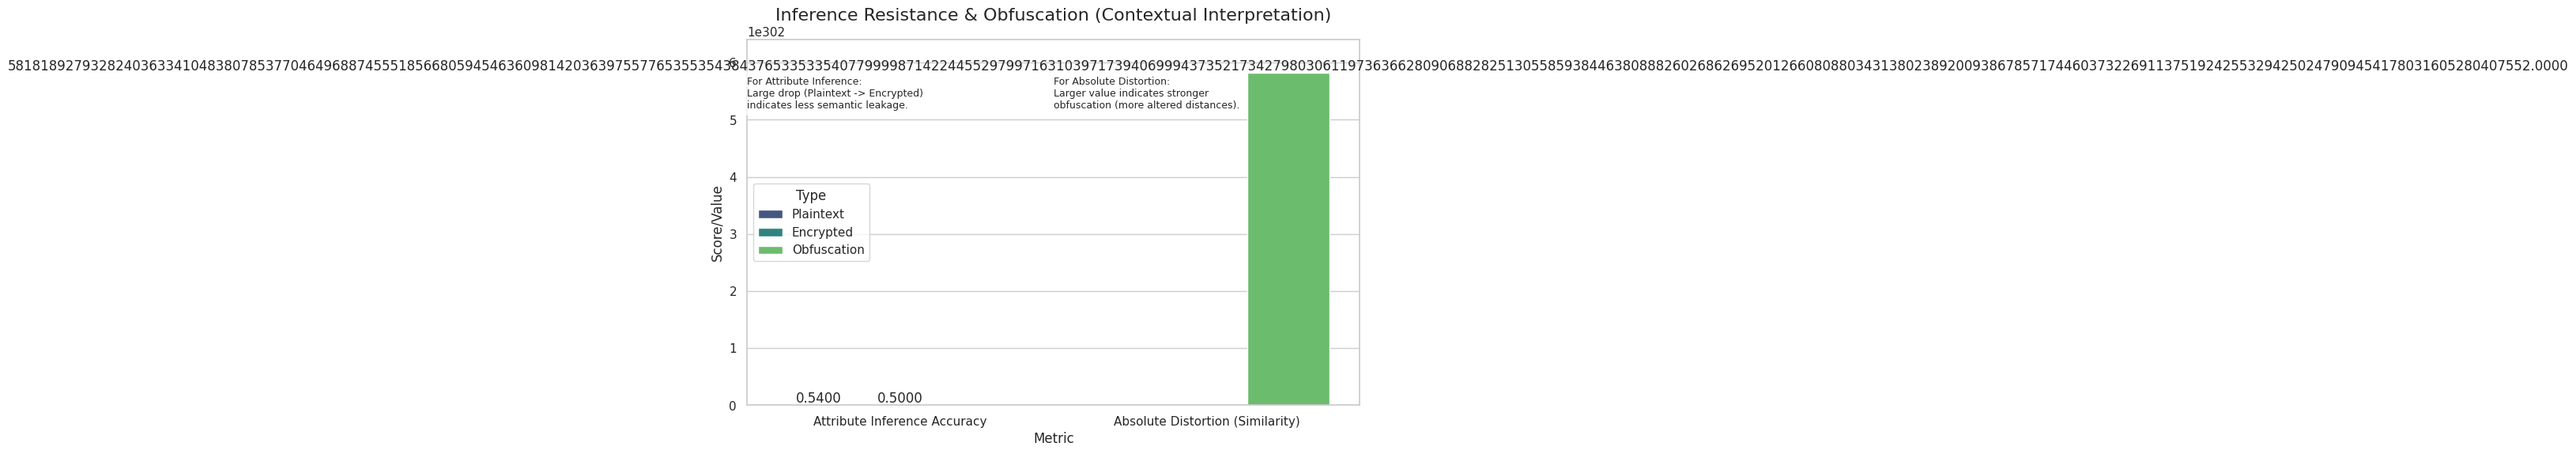


--- Phase 7: Security Visualizations Generated ---


In [23]:
# --- Phase 7: Security Visualization (Improved) ---
print("\n--- Phase 7: Generating Improved Security Visualizations ---")

# Convert security_results to a DataFrame for plotting
security_df = pd.DataFrame([security_results])
pd.set_option('display.max_columns', None) # Ensure all columns are displayed for debug
print("\nSecurity Results DataFrame for plotting:")
print(security_df.to_string())

# Set a professional plotting style
sns.set_theme(style="whitegrid", palette="viridis") # Use a pleasant, professional palette

# --- Chart 1: Security Leakage Metrics (Lower is Better) ---
# Metrics: Spearman ρ, NN Re-ID Hit@1, NN Re-ID Hit@5, Membership Inference AUC
# Interpretation: Lower values are better for privacy (except AUC, where 0.5 is ideal)
# For AUC, we want to show its deviation from 0.5, or just plot it directly and explain.
# Let's plot it directly and use annotations.

leakage_plot_data = []
if "Distance_Structure_Leakage_rho" in security_df.columns and security_df["Distance_Structure_Leakage_rho"].iloc[0] is not None:
    leakage_plot_data.append({"Metric": "Spearman ρ", "Value": security_df["Distance_Structure_Leakage_rho"].iloc[0], "Type": "Leakage"})
if "Similarity_Structure_Leakage_rho" in security_df.columns and security_df["Similarity_Structure_Leakage_rho"].iloc[0] is not None: # For Paillier
    leakage_plot_data.append({"Metric": "Spearman ρ (Similarity)", "Value": security_df["Similarity_Structure_Leakage_rho"].iloc[0], "Type": "Leakage"})

nn_reid_metrics_present = True
for m in ["NN_ReID_Hit@1", "NN_ReID_Hit@5"]:
    if m not in security_df.columns or security_df[m].iloc[0] is None:
        nn_reid_metrics_present = False
        break
if nn_reid_metrics_present:
    leakage_plot_data.append({"Metric": "NN Re-ID Hit@1", "Value": security_df["NN_ReID_Hit@1"].iloc[0], "Type": "Leakage"})
    leakage_plot_data.append({"Metric": "NN Re-ID Hit@5", "Value": security_df["NN_ReID_Hit@5"].iloc[0], "Type": "Leakage"})
    leakage_plot_data.append({"Metric": "NN Re-ID Random Baseline", "Value": security_df["NN_ReID_Random_Baseline"].iloc[0], "Type": "Baseline"})


if "Membership_Inf_AUC" in security_df.columns and security_df["Membership_Inf_AUC"].iloc[0] is not None:
    leakage_plot_data.append({"Metric": "Membership Inf. AUC", "Value": security_df["Membership_Inf_AUC"].iloc[0], "Type": "Leakage"})

leakage_plot_df = pd.DataFrame(leakage_plot_data)

if not leakage_plot_df.empty:
    plt.figure(figsize=(12, 7)) # Adjusted size for clarity
    ax = sns.barplot(x="Metric", y="Value", hue="Type", data=leakage_plot_df, dodge=False, palette={"Leakage": "steelblue", "Baseline": "lightcoral"})

    plt.title("Security Leakage Metrics (Lower values indicate stronger privacy)", fontsize=16)
    plt.ylabel("Score", fontsize=12)
    plt.xlabel("Metric", fontsize=12)
    plt.ylim(0, max(leakage_plot_df["Value"].max() * 1.1, 0.1)) # Dynamic ylim, min 0.1 to show baselines

    # Add interpretations as annotations or lines
    if "Membership Inf. AUC" in leakage_plot_df["Metric"].values:
        plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label="AUC Random Baseline (0.5)")

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge') # Add value labels to bars

    plt.legend(title="Metric Type")
    plt.tight_layout()
    plt.show()
else:
    print("No leakage metrics data available for plotting.")

# --- Chart 2: Inference Resistance & Obfuscation (Contextual) ---
# Metrics: Attribute Inference Accuracy (Plain vs Encrypted), Absolute Distance/Similarity Distortion

resistance_plot_data = []
attr_inf_metrics_present = True
for m in ["Attr_Inf_Plain_Accuracy", "Attr_Inf_Enc_Accuracy"]:
    if m not in security_df.columns or security_df[m].iloc[0] is None:
        attr_inf_metrics_present = False
        break
if attr_inf_metrics_present:
    resistance_plot_data.append({"Metric": "Attribute Inference Accuracy", "Type": "Plaintext", "Value": security_df["Attr_Inf_Plain_Accuracy"].iloc[0]})
    resistance_plot_data.append({"Metric": "Attribute Inference Accuracy", "Type": "Encrypted", "Value": security_df["Attr_Inf_Enc_Accuracy"].iloc[0]})

if "Absolute_Distance_Distortion_Delta" in security_df.columns and security_df["Absolute_Distance_Distortion_Delta"].iloc[0] is not None:
    resistance_plot_data.append({"Metric": "Absolute Distortion (Euclidean)", "Type": "Obfuscation", "Value": security_df["Absolute_Distance_Distortion_Delta"].iloc[0]})
if "Absolute_Similarity_Distortion_Delta" in security_df.columns and security_df["Absolute_Similarity_Distortion_Delta"].iloc[0] is not None:
    resistance_plot_data.append({"Metric": "Absolute Distortion (Similarity)", "Type": "Obfuscation", "Value": security_df["Absolute_Similarity_Distortion_Delta"].iloc[0]})

resistance_plot_df = pd.DataFrame(resistance_plot_data)

if not resistance_plot_df.empty:
    plt.figure(figsize=(10, 6)) # Adjusted size
    ax = sns.barplot(x="Metric", y="Value", hue="Type", data=resistance_plot_df, palette="viridis")

    plt.title("Inference Resistance & Obfuscation (Contextual Interpretation)", fontsize=16)
    plt.ylabel("Score/Value", fontsize=12)
    plt.xlabel("Metric", fontsize=12)

    # Add annotations and interpretation notes
    if "Attribute Inference Accuracy" in resistance_plot_df["Metric"].values:
        plt.text(0, 0.9, "For Attribute Inference:\nLarge drop (Plaintext -> Encrypted)\nindicates less semantic leakage.",
                 horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

    if "Absolute Distortion (Euclidean)" in resistance_plot_df["Metric"].values or "Absolute Distortion (Similarity)" in resistance_plot_df["Metric"].values:
        plt.text(0.5, 0.9, "For Absolute Distortion:\nLarger value indicates stronger\nobfuscation (more altered distances).",
                 horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge')

    plt.ylim(0, max(resistance_plot_df["Value"].max() * 1.1, 0.1)) # Dynamic ylim
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()
else:
    print("No inference resistance/obfuscation data available for plotting.")

print("\n--- Phase 7: Security Visualizations Generated ---")